In [ ]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Datos


El set de datos USArrests contiene el porcentaje de asaltos (Assault), asesinatos (Murder) y secuestros (Rape) por cada 100,000 habitantes para cada uno de los 50 estados de USA (1973). Además, también incluye el porcentaje de la población de cada estado que vive en zonas rurales (UrbanPoP).

In [ ]:
USArrests = sm.datasets.get_rdataset("USArrests", "datasets")
datos = USArrests.data

In [ ]:
datos.info()


<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Murder    50 non-null     float64
 1   Assault   50 non-null     int64  
 2   UrbanPop  50 non-null     int64  
 3   Rape      50 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 2.0+ KB


In [ ]:
datos.head(4)


,Murder,Assault,UrbanPop,Rape
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5


## Exploración inicial


Los dos principales aspectos a tener en cuenta cuando se quiere realizar un PCA es identificar el valor promedio y dispersión de las variables.

La media de las variables muestra que hay tres veces más secuestros que asesinatos y 8 veces más asaltos que secuestros.

In [ ]:
print('----------------------')
print('Media de cada variable')
print('----------------------')
datos.mean(axis=0)

----------------------
Media de cada variable
----------------------


Murder        7.788
Assault     170.760
UrbanPop     65.540
Rape         21.232
dtype: float64

La varianza es muy distinta entre las variables, en el caso de Assault, la varianza es varios órdenes de magnitud superior al resto.



In [ ]:
print('-------------------------')
print('Varianza de cada variable')
print('-------------------------')
datos.var(axis=0)

-------------------------
Varianza de cada variable
-------------------------


Murder        18.970465
Assault     6945.165714
UrbanPop     209.518776
Rape          87.729159
dtype: float64

Si no se estandarizan las variables para que tengan media cero y desviación estándar de uno antes de realizar el estudio PCA, la variable Assault, que tiene una media y dispersión muy superior al resto, dominará la mayoría de las componentes principales.

## Modelo PCA


La clase `sklearn.decomposition.PCA` incorpora las principales funcionalidades que se necesitan a la hora de trabajar con modelos PCA. El argumento `n_components` determina el número de componentes calculados. Si se indica `None`, se calculan todas las posibles (min(filas, columnas) - 1).

Por defecto, `PCA()` centra los valores pero no los escala. Esto es importante ya que, si las variables tienen distinta dispersión, como en este caso, es necesario escalarlas. Una forma de hacerlo es combinar un `StandardScaler()` y un `PCA()` dentro de un `pipeline`. 

In [ ]:
# Entrenamiento modelo PCA con escalado de los datos
# ==============================================================================
pca_pipe = make_pipeline(StandardScaler(), PCA())
pca_pipe.fit(datos)

# Se extrae el modelo entrenado del pipeline
modelo_pca = pca_pipe.named_steps['pca']

Interpretación


Una vez entrenado el objeto `PCA`, pude accederse a toda la información de las componentes creadas.

`components_` contiene el valor de los loadings  ϕ  que definen cada componente (eigenvector). Las filas se corresponden con las componentes principals (ordenadas de mayor a menor varianza explicada). Las filas se corresponden con las variables de entrada.

In [ ]:
# Se combierte el array a dataframe para añadir nombres a los ejes.
pd.DataFrame(
    data    = modelo_pca.components_,
    columns = datos.columns,
    index   = ['PC1', 'PC2', 'PC3', 'PC4']
)

,Murder,Assault,UrbanPop,Rape
PC1,0.535899,0.583184,0.278191,0.543432
PC2,0.418181,0.187986,-0.872806,-0.167319
PC3,-0.341233,-0.268148,-0.378016,0.817778
PC4,0.649228,-0.743407,0.133878,0.089024


Analizar con detalle el vector de loadings que forma cada componente puede ayudar a interpretar qué tipo de información recoge cada una de ellas. Por ejemplo, la primera componente es el resultado de la siguiente combinación lineal de las variables originales:

PC1=0.535899 Murder+0.583184 Assault+0.278191 UrbanPop+0.543432 Rape
 
Los pesos asignados en la primera componente a las variables Assault, Murder y Rape son aproximadamente iguales entre ellos y superiores al asignado a UrbanPoP. Esto significa que la primera componente recoge mayoritariamente la información correspondiente a los delitos. En la segunda componente, es la variable UrbanPoP es la que tiene con diferencia mayor peso, por lo que se corresponde principalmente con el nivel de urbanización del estado. Si bien en este ejemplo la interpretación de las componentes es bastante clara, no en todos los casos ocurre lo mismo, sobre todo a medida que aumenta el número de variables.

La influencia de las variables en cada componente analizarse visualmente con un gráfico de tipo heatmap.



In [ ]:
?plt.imshow(

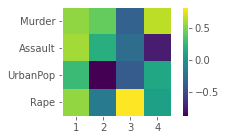

In [ ]:
# Heatmap componentes
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 2))
componentes = modelo_pca.components_
plt.imshow(componentes.T, cmap='viridis')
plt.yticks(range(len(datos.columns)), datos.columns)
plt.xticks(range(len(datos.columns)), np.arange(modelo_pca.n_components_) + 1)
plt.grid(False)
plt.colorbar();

Una vez calculadas las componentes principales, se puede conocer la varianza explicada por cada una de ellas, la proporción respecto al total y la proporción de varianza acumulada. Esta información está almacenada en los atributos `explained_variance_` y `explained_variance_ratio_` del modelo.

----------------------------------------------------
Porcentaje de varianza explicada por cada componente
----------------------------------------------------
[0.62006039 0.24744129 0.0891408  0.04335752]


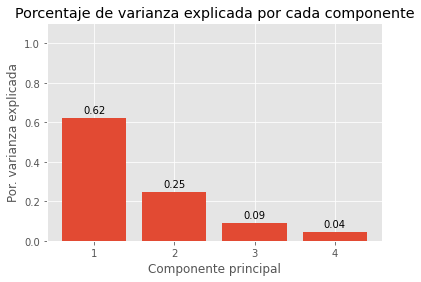

In [ ]:
# Porcentaje de varianza explicada por cada componente
# ==============================================================================
print('----------------------------------------------------')
print('Porcentaje de varianza explicada por cada componente')
print('----------------------------------------------------')
print(modelo_pca.explained_variance_ratio_)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.bar(
    x      = np.arange(modelo_pca.n_components_) + 1,
    height = modelo_pca.explained_variance_ratio_
)

for x, y in zip(np.arange(len(datos.columns)) + 1, modelo_pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,5),
        ha='center'
    )

ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza explicada');

En este caso, la primera componente explica el 62% de la varianza observada en los datos y la segunda el 24.7%. Las dos últimas componentes no superan por separado el 1% de varianza explicada.



------------------------------------------
Porcentaje de varianza explicada acumulada
------------------------------------------
[0.62006039 0.86750168 0.95664248 1.        ]


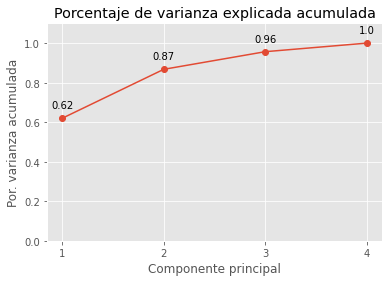

In [ ]:
# Porcentaje de varianza explicada acumulada
# ==============================================================================
prop_varianza_acum = modelo_pca.explained_variance_ratio_.cumsum()
print('------------------------------------------')
print('Porcentaje de varianza explicada acumulada')
print('------------------------------------------')
print(prop_varianza_acum)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.plot(
    np.arange(len(datos.columns)) + 1,
    prop_varianza_acum,
    marker = 'o'
)

for x, y in zip(np.arange(len(datos.columns)) + 1, prop_varianza_acum):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )
    
ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_title('Porcentaje de varianza explicada acumulada')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza acumulada');

Si se empleasen únicamente las dos primeras componentes se conseguiría explicar el 87% de la varianza observada.



## Trasformación


Una vez entrenado el modelo, con el método transform() se puede reducir la dimensionalidad de nuevas observaciones proyectándolas en el espacio definido por las componentes.

In [ ]:
# Proyección de las observaciones de entrenamiento
# ==============================================================================
proyecciones = pca_pipe.transform(X=datos)
proyecciones = pd.DataFrame(
    proyecciones,
    columns = ['PC1', 'PC2', 'PC3', 'PC4'],
    index   = datos.index
)
proyecciones.head()

,PC1,PC2,PC3,PC4
Alabama,0.985566,1.133392,-0.444269,0.156267
Alaska,1.950138,1.073213,2.040003,-0.438583
Arizona,1.763164,-0.745957,0.054781,-0.834653
Arkansas,-0.141420,1.119797,0.114574,-0.182811
California,2.523980,-1.542934,0.598557,-0.341996


In [ ]:
proyecciones.plot.scatter(*["PC1", "PC2"])

La transformación es el resultado de multiplicar los vectores que definen cada componente con el valor de las variables. Puede calcularse de forma manual:



In [ ]:
proyecciones = np.dot(modelo_pca.components_, scale(datos).T)
proyecciones = pd.DataFrame(proyecciones, index = ['PC1', 'PC2', 'PC3', 'PC4'])
proyecciones = proyecciones.transpose().set_index(datos.index)
proyecciones.head()

,PC1,PC2,PC3,PC4
Alabama,0.985566,1.133392,-0.444269,0.156267
Alaska,1.950138,1.073213,2.040003,-0.438583
Arizona,1.763164,-0.745957,0.054781,-0.834653
Arkansas,-0.141420,1.119797,0.114574,-0.182811
California,2.523980,-1.542934,0.598557,-0.341996


## Reconstrucción


Puede revertirse la transformación y reconstruir el valor inicial con el método inverse_transform(). Es importante tener en cuenta que, la reconstrucción, solo será completa si se han incluido todas las componentes.

In [ ]:
# Recostruccion de las proyecciones
# ==============================================================================
recostruccion = pca_pipe.inverse_transform(X=proyecciones)
recostruccion = pd.DataFrame(
                    recostruccion,
                    columns = datos.columns,
                    index   = datos.index
)
print('------------------')
print('Valores originales')
print('------------------')
display(recostruccion.head())

print('---------------------')
print('Valores reconstruidos')
print('---------------------')
display(datos.head())

------------------
Valores originales
------------------


,Murder,Assault,UrbanPop,Rape
Alabama,13.2,236.0,58.0,21.2
Alaska,10.0,263.0,48.0,44.5
Arizona,8.1,294.0,80.0,31.0
Arkansas,8.8,190.0,50.0,19.5
California,9.0,276.0,91.0,40.6


---------------------
Valores reconstruidos
---------------------


,Murder,Assault,UrbanPop,Rape
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6
